# Projet : Forage de données IFT870

# Augmentaion de la région d'intérêt

Ce notebook contiendra des traces de la méthode utilisée pour augmenter la région d'intérêt de la tumeur.

### Installation des dépendances

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from scipy import ndimage
from pymatreader import read_mat


# On se demande pourquoi pip install en windows powershell ne l'installe pas.
# !pip install pymatreader 

### Importation de données

In [ ]:
nb_images = 3064

class_names = ['meningiome', 'gliome', 'pituitaire']

def load_data(type, nb_images=3064):
    data = [ [], [], [] ] # index : meningioma = 0, glioma = 1, pituitary = 2
    if type == 'mat':
        for i in range(1, nb_images):
            dir = "dataset/mat/" + str(i) + ".mat"
            mat_file = read_mat(dir)
            classe = int(mat_file["cjdata"]["label"]-1) # -1 car les indices commencent a 1 dans les fichiers mat
            data[classe].append(mat_file)
        return data
    
    if type == 'png':
        class_nb = [1, 2, 3]    
        for i in range(len(class_nb)):
            dir = "dataset/png/" + str(class_nb[i])
            for path in os.listdir(dir):
                # print(dir)
                # print(path)
                data[i].append(io.imread(dir + "/" + path))
        return data


mat_data = load_data(type='mat')
png_data = load_data(type='png', nb_images=2)


### Rappel : Visualisation d'une donnée au format mat

In [ ]:
mat1 = mat_data[1][0]
plt.imshow(mat1["cjdata"]['image'], interpolation='nearest')
print('Etiquette de l''image : ', class_names[int(mat1["cjdata"]["label"]-1)])
plt.show()

tumorMask = mat1['cjdata']['tumorMask']
plt.imshow(tumorMask, cmap='Greys', interpolation='nearest')
plt.title('Région d\'intérêt (tumeur)')
plt.show()

### Dilatation avec un filtre carré et un filtre circulaire


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
fig.suptitle('Région d\'intérêt (tumeur)');

# Filtre carre
dilation_structure = np.ones((20,20))
dilatedTumorMask_square = ndimage.binary_dilation(tumorMask, dilation_structure)
ax1.title.set_text('Filtre carré')
ax1.imshow(dilatedTumorMask_square, cmap='Greys', interpolation='nearest')

# Filtre circulaire
 
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

circular_mask = create_circular_mask(20,20)

dilatedTumorMask_cicle = ndimage.binary_dilation(tumorMask, circular_mask)
ax2.title.set_text('Filtre circulaire')
ax2.imshow(dilatedTumorMask_cicle, cmap='Greys', interpolation='nearest');


# Difference
differences = np.logical_xor(dilatedTumorMask_square, dilatedTumorMask_cicle)
ax3.title.set_text('Différences')
ax3.imshow(differences, cmap='Greys', interpolation='nearest');




### Partitionnement

32
dim 512
16240
16240


(array([1927., 3532., 3095., 2780., 1908., 1288.,  868.,  450.,  284.,
         108.]),
 array([7.18311085e-02, 9.07264636e+00, 1.80734616e+01, 2.70742769e+01,
        3.60750921e+01, 4.50759074e+01, 5.40767226e+01, 6.30775379e+01,
        7.20783531e+01, 8.10791684e+01, 9.00799836e+01]),
 <BarContainer object of 10 artists>)

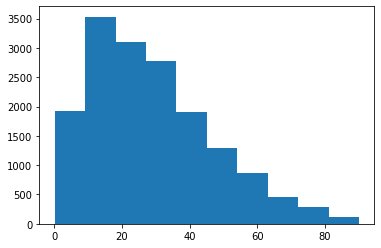

In [171]:
# Cette fonction calcule la distance Minkowski entre un vecteur x et une matrice Y (Atelier 3)
def minkowski_mat(x, Y, p=2):
    return (np.sum((np.abs(x - Y)) ** p, axis=1)) ** (1.0 / p)

# Cette fonction retourne une lise de couple au format [ [x1,y1], [x2,y2], ...,  [xn,yn] ]
def make_couple(data):
    # Verification
    if not( len(data) % 2 == 0):
        print('La dimension des données doit etre paire')
        return
    
    couples = []
    for i in range(int(len(data)/2.0)):
        x.append([data[2*i], data[2*i + 1]])
    
    return couples


# Cette fonction calcule la distance la plus courte entre un element du mask et la bordure
#   border - doit etre sous format couple ( voir make_couple(data) )
#   mask_data - doit etre au format TRUE FALSE
def dist_elem_mask(border, mask_data):
    print(len(border))
    count = 0
    dim = len(mask_data)
    dist_mask = np.ndarray((dim,dim)) # distances with 0 values
    min_distances = [] # distances only
    print('dim', dim)
    
    for x in range(dim):
        for y in range(dim):
            if mask_data[x][y] == 1:
                min_dist = float('inf')
                for border_point in border:
                    delta_x = abs(x - border_point[0])
                    delta_y = abs(y - border_point[1])
                    dist = (delta_x**2 + delta_y**2)**(1/2)
                    if dist < min_dist:
                        min_dist = dist
                min_distances.append(min_dist)
                dist_mask[x][y] = min_dist
            else:
                dist_mask[x][y] = None
                
    return dist_mask, min_distances





border = make_couple(mat1['cjdata']['tumorBorder'])
mask_with_distances, distances_only = dist_elem_mask(border, mat1['cjdata']['tumorMask'])
print(np.count_nonzero(mat1['cjdata']['tumorMask']))
print(len(distances_only))

plt.hist(distances_only)